Use ml.m5.4xlarge and DataScience 2.0 Python 3

In [1]:
# !pip install -q transformers>=4.25.1
# !pip install -q accelerate>=0.20.3
# !pip install -q datasets>=2.11
# !pip install -q evaluate>=0.3.0
# !pip install -q peft >=0.4.0
# !pip install torch==1.13.1
# !pip install wordcloud==1.9.3
# !pip install contractions

In [4]:
import pandas as pd
import numpy as np
import requests
import re
import os
import sys
import gzip
import json
import random
from tqdm import trange
import torch # PyTorch is a powerful deep learning library.
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from tabulate import tabulate
from sklearn.model_selection import train_test_split # for splitting data into train and test sets.
from sklearn.feature_extraction.text import TfidfVectorizer # for converting text data into vectors.
from sklearn.svm import SVC # Support Vector Machine Classifier model.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score 
# above line imports different metrics to evaluate the model performance.
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes model.
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier model.
from sklearn.metrics import classification_report # for generating a comprehensive report of model performance.
from datasets import load_dataset 
# This function allows loading dataset from Huggingface's datasets library. 
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, BertForSequenceClassification

import pandas as pd
import numpy as np
import re
import json
import torch
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import sagemaker
from sagemaker.huggingface import HuggingFace
import boto3

2024-06-19 07:21:10.772946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


# [Load the dataset](#Methodology)

In this step we will load the dataset into a pandas DataFrame, and explore it to understand its structure, format, and attributes in order to identify the specific column(s) or attribute(s) that contain the textual data that we will be will be working with. This dataset will be loaded from huggingface

In [5]:
import pandas as pd

# Read the CSV files
fake_news_articles = pd.read_csv('data/Fake.csv')
true_news_articles = pd.read_csv('data/True.csv')

# Assign labels: 0 for fake, 1 for true
fake_news_articles['label'] = 0
true_news_articles['label'] = 1

# Combine the two DataFrames into one
frames = [fake_news_articles, true_news_articles]
news_df = pd.concat(frames)

# Display the first few rows of the combined DataFrame
print(news_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


### News dataset

In [6]:
print(news_df.head(),"\n\n")
print("Unique labels",news_df.label.unique())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0   


Unique labels [0 1]


**Result** 

- The train and test datasets target `labels` correspond to `0 - Negative` and `1 - Positive` and a `text` field.

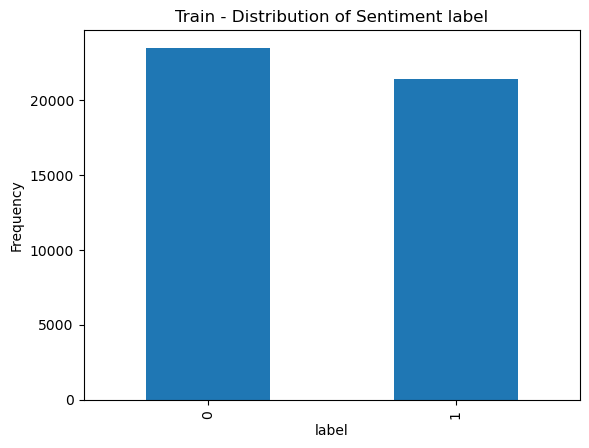

In [7]:
news_df['label'].value_counts().plot(kind='bar')
plt.title('Train - Distribution of Sentiment label')
plt.ylabel('Frequency')
plt.show()

**Result**

- The IMDB dataset has a even distribution of positive and negative reviews

### Print a random row above 95% percentile

In [8]:
# Get a random row from the dataframe
# Get the row above 95% percentile of the column news_df["Phrase"]
long_row = news_df[news_df["text"].str.len() > news_df["text"].str.len().quantile(0.98)]

random_row = long_row.sample(n=1)

# Convert the row to JSON format
long_row_json = random_row.to_json(orient='records')

# Parse the JSON string to a python dict
random_row_dict = json.loads(long_row_json)

# Print the dict in pretty format
print(json.dumps(random_row_dict[0], indent=4))
Random_ID_value = random_row.index[0]

{
    "title": "DOCTOR MENTIONED In Hillary Email Released By Wikileaks Found DEAD In Apartment\u2026Police Say He Committed Suicide By Stabbing Himself To Death??",
    "text": "54-year-old Dr. Dean Lorich, Associate Director of Orthopaedic Trauma Service at the Hospital for Special Surgery, as well as the Chief of the Orthopedic Trauma Service at NewYork-Presbyterian Hospital, was found dead in his apartment earlier this week.According to New York City police, he committed suicide by stabbing himself to death.That s a pretty normal way to commit suicide right?It s like the time when former President of the United Nations General Assembly John Ashe, was found dead in his apartment only days before he was set to testify against the Clintons in a corruption case. The official reports indicated that Ashe died of a heart attack.The problem, however, is that police on the scene reported Ashe died when his throat was crushed during a work-out accident.Adding to the mysterious nature of Ashe

In [9]:
print(Random_ID_value)

9207


**result**
- On printing random row we see that the text fields are not clean, we will perform data to clean up punctuations, stop words, ASCII characters, dates etc. 

### Text Length Analysis

Calculate the length of each review and analyze the distribution of lengths to garner insights into the average length of reviews, the trange of lengths, etc.

count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text, dtype: float64


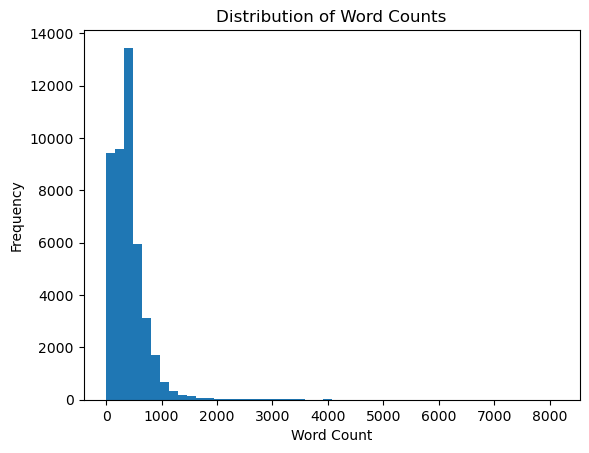

In [10]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Print out a summary of the word count statistics
print(news_df['text'].apply(word_count).describe())

# Plot a histogram of the word counts
plt.hist(news_df['text'].apply(word_count), bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**Result**
- The distribution shows the word count tranges from 4 words to 2,278 with an average of 228 words and a standard deviation of 168.

# [Apply Word2vec for Semantec Analsyis, Key Word and Topic analsysis](#Methodology)

We will use word2vec for semantic analysis to perform keyword extraction and gain insights into the main topics and themes discussed in the reviews.

Word2vec represents words as vectors in a high-dimensional space, capturing their semantic relationships. This allows us to identify key words that are closely related to the main topics and themes in the reviews. This will help us extract more meaningful insights from the text data and overcome the limitations of using simple frequency-based methods like TF-IDF.


In [11]:
!pip install gensim

In [12]:
# Visualizing the Word cloud using Word2vec
from gensim.models import Word2Vec

# Fit and transform the reviews
reviews = news_df['text'].tolist()
reviews_tokenized = [review.split() for review in reviews]

# Train word2vec model
model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=1)

# Get word frequencies from the trained model
word_freq = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

**result**

- In our first pass at keyword analsisys, we find that the most common word were stop words, specifically `the` is the most common word followed by `and` and `of`. We will review this results after cleaning up the datasets

# [Cleaning the Dataset]((#Methodology))

In this section, we will perform text cleaning that will involve several processes. The first process is fixing contractions. Contractions are words or combinations of words that are shortened by dropping letters and replacing them with an apostrophe. For example, "don't" is a contraction of "do not". Fixing these contractions will ensure that our text data is consistent and easier to analyze. 

The next process is removing non-ASCII characters. ASCII characters are the standard characters in the English language, including all letters, numbers, and common symbols. Non-ASCII characters include special symbols and characters from other languages. Removing these will ensure that our text data only contains standard English characters.

The third process is converting all text to lowercase. This is important because in text analysis, 'Word' and 'word' are considered as two different words due to the difference in case. By converting everything to lowercase, we can avoid this issue and make our analysis more accurate.

The final process is removing punctuations. Punctuations can cause issues in text analysis as they can create different tokens or words. For example, 'word,' and 'word' would be considered as two different words due to the comma. By removing punctuations, we can avoid this issue and make our text data cleaner and easier to analyze.

### Contractions

We used the [contractions](https://github.com/kootenpv/contractions) package to resolve contractions and  (and slang), `examples:you're -> you are`



In [13]:
import contractions
news_df["text_clean"] = news_df['text'].apply(lambda x: contractions.fix(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54-year-old Dr. Dean Lorich, Associate Director of Orthopaedic Trauma Service at the Hospital for Special Surgery, as well as the Chief of the Orthopedic Trauma Service at NewYork-Presbyterian Hospita'

### Remove URLs
Remove URL from text

In [14]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_URL(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54-year-old Dr. Dean Lorich, Associate Director of Orthopaedic Trauma Service at the Hospital for Special Surgery, as well as the Chief of the Orthopedic Trauma Service at NewYork-Presbyterian Hospita'

### Remove Non-ASCI Characters

In [15]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 

news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_non_ascii(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54-year-old Dr. Dean Lorich, Associate Director of Orthopaedic Trauma Service at the Hospital for Special Surgery, as well as the Chief of the Orthopedic Trauma Service at NewYork-Presbyterian Hospita'

### Make characters lowercase

In [16]:
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: x.lower())
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54-year-old dr. dean lorich, associate director of orthopaedic trauma service at the hospital for special surgery, as well as the chief of the orthopedic trauma service at newyork-presbyterian hospita'

### Remove html

In [17]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_html(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54-year-old dr. dean lorich, associate director of orthopaedic trauma service at the hospital for special surgery, as well as the chief of the orthopedic trauma service at newyork-presbyterian hospita'

### Remove symbols

In [18]:
def remove_symbols(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_symbols(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54-year-old dr. dean lorich, associate director of orthopaedic trauma service at the hospital for special surgery, as well as the chief of the orthopedic trauma service at newyork-presbyterian hospita'

### Remove Special characters

In [19]:
def remove_special_chars(text):
    """
        Remove special characters (\n, \, ', "",) in sample text
    """
    # Replace \n, \ and ' with empty string
    text = text.replace('\n', ' ').replace('\\', ' ').replace('\'', ' ').replace('\"', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ')
    return text

# Assuming news_df is a DataFrame with a column "text_clean" containing text data
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_special_chars(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54 year old dr. dean lorich, associate director of orthopaedic trauma service at the hospital for special surgery, as well as the chief of the orthopedic trauma service at newyork presbyterian hospita'

### Remove punctuations

In [20]:
import re
def remove_punct(text):

    # Replace punctuation with space, except for decimal points in numerical values
    return re.sub(r'(?:(?<!\d)[.,;()]|[.,;()](?!\d))', '', text)

# Apply the function to the dataframe
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_punct(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'54 year old dr dean lorich associate director of orthopaedic trauma service at the hospital for special surgery as well as the chief of the orthopedic trauma service at newyork presbyterian hospital w'

**result**
- In removing punctuations, we needed to be carefull not to remove punctuations in between numbers in order to preseve the information in text, doing so would have caused values such as `12.4 million` -> `124 million` which would have changed the meaning of the text

# [Text Preprocessing](#Methodology)

In this section, we will perform text preprocessing that will involve several steps. First, we will carry out tokenization on the textual data. This process involves splitting the text into individual tokens, which could be words, punctuation, or other meaningful units. We will use an appropriate tokenization technique or library to achieve this. 

Next, we will remove stop words from the tokenized text. Stop words are common words such as "the," "is," "and" that do not carry significant meaning. We will use a standard stop word list or library to identify and remove these words from our text. 

Following this, we will apply stemming to the tokens. Stemming is a process that reduces each word to its base or root form. We will use a suitable stemming algorithm or library to perform this task. 

Finally, we will implement lemmatization on the tokens. Lemmatization is a process that transforms each word into its canonical or dictionary form. We will use a reliable lemmatization technique or library for this purpose. 

### Tokenization

Tokenization is the process of breaking down text into smaller parts called tokens which help in understanding the context or developing the model for NLP (Natural Language Processing). The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words. 

For instance, consider the text "The quick brown fox jumps over the lazy dog". In tokenization, this sentence is broken down into individual words: 'The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'.

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
import nltk
from nltk.tokenize import word_tokenize

news_df['tokenized'] = news_df['text_clean'].apply(word_tokenize)
news_df.iloc[Random_ID_value]['tokenized'][:200]

['54',
 'year',
 'old',
 'dr',
 'dean',
 'lorich',
 'associate',
 'director',
 'of',
 'orthopaedic',
 'trauma',
 'service',
 'at',
 'the',
 'hospital',
 'for',
 'special',
 'surgery',
 'as',
 'well',
 'as',
 'the',
 'chief',
 'of',
 'the',
 'orthopedic',
 'trauma',
 'service',
 'at',
 'newyork',
 'presbyterian',
 'hospital',
 'was',
 'found',
 'dead',
 'in',
 'his',
 'apartment',
 'earlier',
 'this',
 'weekaccording',
 'to',
 'new',
 'york',
 'city',
 'police',
 'he',
 'committed',
 'suicide',
 'by',
 'stabbing',
 'himself',
 'to',
 'deaththat',
 's',
 'a',
 'pretty',
 'normal',
 'way',
 'to',
 'commit',
 'suicide',
 'right',
 '?',
 'it',
 's',
 'like',
 'the',
 'time',
 'when',
 'former',
 'president',
 'of',
 'the',
 'united',
 'nations',
 'general',
 'assembly',
 'john',
 'ashe',
 'was',
 'found',
 'dead',
 'in',
 'his',
 'apartment',
 'only',
 'days',
 'before',
 'he',
 'was',
 'set',
 'to',
 'testify',
 'against',
 'the',
 'clintons',
 'in',
 'a',
 'corruption',
 'case',
 'the',
 

**result**
- On tokenization, we find that `word_tokenize` does not catch numbers such as `175m` which represents 175 million. Since the NLP downstream task is sentiment, analysis these definitions of tokens are fine and can be left as is

### Remove stop words

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# Removing stopwords.
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
news_df['stopwords_removed'] = news_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
news_df.iloc[Random_ID_value]['stopwords_removed'][:200]

['54',
 'year',
 'old',
 'dr',
 'dean',
 'lorich',
 'associate',
 'director',
 'orthopaedic',
 'trauma',
 'service',
 'hospital',
 'special',
 'surgery',
 'well',
 'chief',
 'orthopedic',
 'trauma',
 'service',
 'newyork',
 'presbyterian',
 'hospital',
 'found',
 'dead',
 'apartment',
 'earlier',
 'weekaccording',
 'new',
 'york',
 'city',
 'police',
 'committed',
 'suicide',
 'stabbing',
 'deaththat',
 'pretty',
 'normal',
 'way',
 'commit',
 'suicide',
 'right',
 '?',
 'like',
 'time',
 'former',
 'president',
 'united',
 'nations',
 'general',
 'assembly',
 'john',
 'ashe',
 'found',
 'dead',
 'apartment',
 'days',
 'set',
 'testify',
 'clintons',
 'corruption',
 'case',
 'official',
 'reports',
 'indicated',
 'ashe',
 'died',
 'heart',
 'attackthe',
 'problem',
 'however',
 'police',
 'scene',
 'reported',
 'ashe',
 'died',
 'throat',
 'crushed',
 'work',
 'accidentadding',
 'mysterious',
 'nature',
 'ashe',
 'death',
 'fact',
 'slated',
 'court',
 'monday',
 'chinese',
 'businessm

count    44898.000000
mean       240.672836
std        210.325345
min          0.000000
25%        123.000000
50%        212.000000
75%        302.000000
max       5107.000000
Name: word_count, dtype: float64


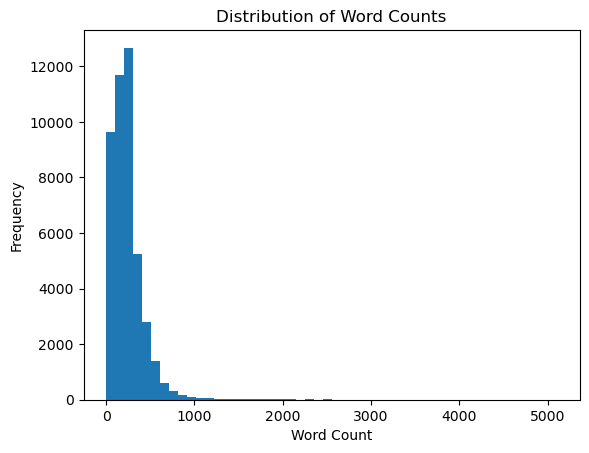

In [25]:
# Apply the join function to the 'stopwords_removed' column
news_df['word_count'] = news_df['stopwords_removed'].apply(' '.join).apply(word_count)

# Print out a summary of the word count statistics
print(news_df['word_count'].describe())

# Plot a histogram of the word counts
plt.hist(news_df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**result**
- After removing the stop words, maximum length of `text` goes from 4 to 1178 words. 

In [26]:
news_df.iloc[Random_ID_value]['stopwords_removed'][:200]

['54',
 'year',
 'old',
 'dr',
 'dean',
 'lorich',
 'associate',
 'director',
 'orthopaedic',
 'trauma',
 'service',
 'hospital',
 'special',
 'surgery',
 'well',
 'chief',
 'orthopedic',
 'trauma',
 'service',
 'newyork',
 'presbyterian',
 'hospital',
 'found',
 'dead',
 'apartment',
 'earlier',
 'weekaccording',
 'new',
 'york',
 'city',
 'police',
 'committed',
 'suicide',
 'stabbing',
 'deaththat',
 'pretty',
 'normal',
 'way',
 'commit',
 'suicide',
 'right',
 '?',
 'like',
 'time',
 'former',
 'president',
 'united',
 'nations',
 'general',
 'assembly',
 'john',
 'ashe',
 'found',
 'dead',
 'apartment',
 'days',
 'set',
 'testify',
 'clintons',
 'corruption',
 'case',
 'official',
 'reports',
 'indicated',
 'ashe',
 'died',
 'heart',
 'attackthe',
 'problem',
 'however',
 'police',
 'scene',
 'reported',
 'ashe',
 'died',
 'throat',
 'crushed',
 'work',
 'accidentadding',
 'mysterious',
 'nature',
 'ashe',
 'death',
 'fact',
 'slated',
 'court',
 'monday',
 'chinese',
 'businessm

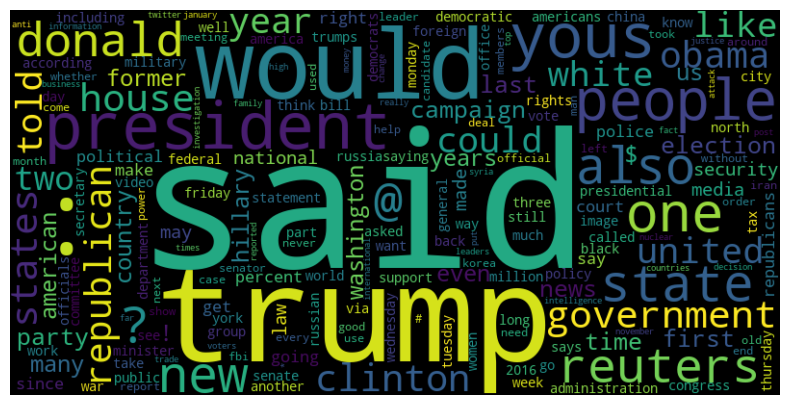

In [27]:
# Visualizing the Word cloud using Word2vec
from gensim.models import Word2Vec

# Fit and transform the reviews
reviews = news_df['stopwords_removed'].apply(' '.join).tolist()
reviews_tokenized = [review.split() for review in reviews]

# Train word2vec model
model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=1)

# Get word frequencies from the trained model
word_freq = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**result**
- After incoperating the stop word removal, we noticed that have a key words now related to `movie`, `film` , `one` and `good`. 

# [Train and test datasets](#Methodology)

In [28]:
### Import Models

In [52]:
# Tokenize
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512, force_download=True)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [30]:
news_df["stopwords_removed"] = news_df["stopwords_removed"].apply(' '.join)

In [31]:
text = news_df['stopwords_removed']
labels = torch.from_numpy(np.array(news_df.label))

**BERT requires the following preprocessing steps**


Incorporate special tokens:
- Commence each sentence with a [CLS] token (identified as 101)
- Conclude each sentence with a [SEP] token (identified as 102)

Achieve uniform sentence lengths:
- Padding is employed to equalize shorter sequences to the required length by adding convenience values. Longer sequences are shortened.
- Padding tokens, known as [PAD], are recognized as ID 0.
- The permissible maximum sequence length is 512 tokens.

Develop an attention mask:
- A list of binary values (0s and 1s) indicating whether the model should take into account certain tokens while learning their contextual representation. Padding ([PAD]) tokens are expected to have a value of 0.
This process can be visualized as follows:  


<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*vaw98m1VVncgKxNFWI0d2Q.png" alt="drawing" width="800"/>

We will use a very helpfull function [encode_plus](https://huggingface.co/docs/transformers/main_classes/tokenizer?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus) provided in the Tokenizer class to procepcessing.


--- 

### Tokenization

In [32]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_4187/1155887400.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [33]:
def print_shortest_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of the shortest text sample'''
  
  # Get the length of each sentence in the dataset
  sentence_lengths = [len(s) for s in token_id]
  
  # Find the index of the shortest sentence
  shortest_index = np.argmin(sentence_lengths)
  
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[shortest_index]))
  token_ids = [i.item() for i in token_id[shortest_index]]
  attention = [i.item() for i in attention_masks[shortest_index]]

  table = np.array([tokens, token_ids, attention]).T[:180]
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_shortest_sentence_encoding()

╒════════════╤═════════════╤══════════════════╕
│ Tokens     │   Token IDs │   Attention Mask │
╞════════════╪═════════════╪══════════════════╡
│ [CLS]      │         101 │                1 │
├────────────┼─────────────┼──────────────────┤
│ donald     │        6221 │                1 │
├────────────┼─────────────┼──────────────────┤
│ trump      │        8398 │                1 │
├────────────┼─────────────┼──────────────────┤
│ wish       │        4299 │                1 │
├────────────┼─────────────┼──────────────────┤
│ americans  │        4841 │                1 │
├────────────┼─────────────┼──────────────────┤
│ happy      │        3407 │                1 │
├────────────┼─────────────┼──────────────────┤
│ new        │        2047 │                1 │
├────────────┼─────────────┼──────────────────┤
│ year       │        2095 │                1 │
├────────────┼─────────────┼──────────────────┤
│ leave      │        2681 │                1 │
├────────────┼─────────────┼────────────

# Save to S3

In [34]:
# Convert to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(news_df[['stopwords_removed', 'label']])
# Split the dataset
train_test_split = hf_dataset.train_test_split(test_size=0.2)

In [40]:
def tokenize(batch):
    return tokenizer(batch['stopwords_removed'], 
                      padding='max_length', 
                      truncation=True) 

In [41]:
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [42]:
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

In [44]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'fake-news-dataset'
train_path = f's3://{bucket}/{prefix}/train'
test_path = f's3://{bucket}/{prefix}/test'

In [45]:
def save_dataset_to_s3(dataset_path, bucket, prefix):
    s3 = boto3.client('s3')
    for root, _, files in os.walk(dataset_path):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, dataset_path)
            s3_path = f'{prefix}/{relative_path}'
            s3.upload_file(local_path, bucket, s3_path)

In [46]:

train_dataset.save_to_disk('train_dataset')  # Save locally first
test_dataset.save_to_disk('test_dataset')   # Save locally first
save_dataset_to_s3('train_dataset', bucket, f'{prefix}/train')  
save_dataset_to_s3('test_dataset', bucket, f'{prefix}/test')


Saving the dataset (0/1 shards):   0%|          | 0/35918 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8980 [00:00<?, ? examples/s]

In [47]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [54]:
# Training with Hugging Face on SageMaker
hyperparameters = {
    'epochs': 2,
    'train_batch_size': 32,
    'model_id': model_name,
}

In [55]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}
]

In [ ]:
# include the image URI:https://discuss.huggingface.co/t/error-deploying-bert-on-sagemaker/8401
# Bug here https://discuss.huggingface.co/t/error-deploying-bert-on-sagemaker/8401

In [66]:
huggingface_estimator = HuggingFace(
    entry_point='train.py',
    source_dir='./scripts',
    instance_type='ml.m5.large',
    instance_count=1,
    transformers_version='4.26',
    pytorch_version='1.13',
    # image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:2.1.0-transformers4.37.0-cpu-py310-ubuntu22.04",
    # image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04",
    image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.13.1-transformers4.26.0-gpu-py39-cu117-ubuntu20.04",
    py_version='py39',
    role=sagemaker.get_execution_role(),
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions
)

In [72]:
huggingface_estimator.fit({'train': train_path, 'test': test_path})

INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2024-06-19-12-45-24-063


2024-06-19 12:45:24 Starting - Starting the training job...
2024-06-19 12:45:44 Starting - Preparing the instances for training...
2024-06-19 12:46:15 Downloading - Downloading input data......
2024-06-19 12:47:16 Downloading - Downloading the training image........................
2024-06-19 12:51:07 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-06-19 12:51:11,703 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-06-19 12:51:11,705 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-19 12:51:11,707 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-19 12:51:11,719 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-06-19 12:51:11,727 sagemaker_pytorch_container.training INFO     

In [108]:
model_path = huggingface_estimator.model_data
print(f"Model artifact saved at: {model_path}")

Model artifact saved at: s3://sagemaker-us-east-1-873309100258/huggingface-pytorch-training-2024-06-19-12-45-24-063/output/model.tar.gz


In [109]:
from sagemaker.huggingface import HuggingFaceModel

# Define the Hugging Face model
huggingface_model = HuggingFaceModel(
    model_data=model_path,
    role=sagemaker.get_execution_role(),
    transformers_version='4.6',        # Transformers version
    pytorch_version='1.7',             # PyTorch version
    py_version='py36',                 # Python version
    entry_point='inference.py',         # Your inference script
    source_dir='./scripts',
)

# Deploy the model
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-873309100258/huggingface-pytorch-training-2024-06-19-12-45-24-063/output/model.tar.gz), script artifact (./scripts), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-873309100258/huggingface-pytorch-inference-2024-06-19-18-30-02-936/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2024-06-19-18-30-12-489
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2024-06-19-18-30-13-224
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2024-06-19-18-30-13-224


------!

In [113]:
# Testing the model
random_sample = news_df.sample(n=1)
test_text = random_sample['stopwords_removed'].values[0]
prediction = predictor.predict({"inputs": test_text[:512]})
print(f"Text: {test_text}")
print(f"Prediction: {prediction}")

Text: moscow reuters kremlin said monday still premature say anything certain possible meeting russian president vladimir putin yous counterpart donald trump next month definite arrangements made two leaders widely expected hold first personal meeting attend g20 summit germany july anyway putin trump present event city time anyway possibility meeting putins spokesman dmitry peskov told conference call reporters let us wait g20 summit repeat : regret far definite arrangements regarding meeting
Prediction: [{'label': 'positive', 'score': 0.9982740879058838}]


In [114]:
# Delete endpoint
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: huggingface-pytorch-inference-2024-06-19-18-30-12-489
INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-inference-2024-06-19-18-30-13-224
INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-inference-2024-06-19-18-30-13-224


We create a metric_definition dictionary that contains regex-based definitions that will be used to parse the job logs and extract metric

In [115]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [2]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

# Deploy to custom endpoint using Hugginface [Source](https://github.com/huggingface/notebooks/blob/main/sagemaker/10_deploy_model_from_s3/deploy_transformer_model_from_s3.ipynb)